Les bibliothèques suivantes sont nécessaires pour exécuter ce notebook :


<a href="https://colab.research.google.com/github/RemiArbache/style-transfer-M2/blob/main/notebook/neural_style.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0


Les images de contenu et de style sont tout d’abord chargées, ce qui permet de remarquer les tailles différentes.

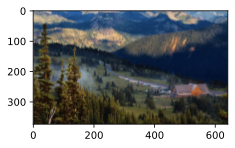

In [40]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
from PIL import Image

npx.set_np()

d2l.set_figsize()
content_img = image.imread('./img/rainier.jpg')
d2l.plt.imshow(content_img.asnumpy());

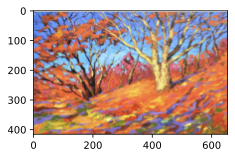

In [6]:
style_img = image.imread('./img/style.jpg')
d2l.plt.imshow(style_img.asnumpy());

## **Prétraitement et post-traitement**

Une fonction de prétraitement est donc définie pour standardiser chacun des trois canaux RVB d’une image donnée et transforme les résultats au format d’entrée du CNN. La fonction de post-traitement restaure les valeurs de pixel dans l'image de sortie à leurs valeurs d'origine avant la normalisation. La fonction d'impression d'image nécessite que chaque pixel ait une valeur entre 0 et 1, donc toute valeur inférieure à 0 ou supérieure à 1 est remplacée respectivement par 0 ou 1. 


In [21]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return np.expand_dims(img.transpose(2, 0, 1), axis=0)

def postprocess(img):
    img = img[0].as_in_ctx(rgb_std.ctx)
    return (img.transpose(1, 2, 0) * rgb_std + rgb_mean).clip(0, 1)

## **Extraction des caractéristiques**

Le modèle VGG-19 pré-entraîné sur le jeu de données ImageNet est utilisé pour extraire les caractéristiques de l'image.


In [22]:
pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

Afin d'extraire les caractéristiques de contenu et les caractéristiques de style de l'image, la sortie de certaines couches dans le réseau VGG peuvent être sélectionnées. Une couche est choisie pour générer les caractéristiques de contenu de l’image, de préférence plus proche de la sortie pour éviter la conservation excessive de détails (couche de contenu). Pour extraire les caractéristiques de style locales et globales, la sortie de différentes couches sont sélectionnées (couches de style).

De manière générale, plus on est proche de la couche d'entrée, plus il est facile d'extraire les détails de l'image, et vice versa, plus il est facile d'extraire les informations globales de l'image.

Le réseau VGG utilise 5 blocs convolutifs. Dans l'expérience, nous choisissons la dernière couche convolutive du quatrième bloc convolutif comme couche de contenu et la première couche convolutive de chaque bloc convolutif comme couches de style. Les indices de ces couches peuvent être obtenus en imprimant l'instance pretrained_net.

In [23]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

Pour l’extraction des caractéristiques à l’aide des couches VGG, seules les couches précédant la dernière couche utilisée (de contenu ou de style) sont nécessaires pour les extractions. En effet, la sortie de la ne couche est calculée suite au passage par les couches précédentes, mais les couches suivantes ne seront pas utilisées. 

In [24]:
net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

Un calcul couche par couche est effectué pour conserver les sorties des couches intermédiaires définies comme couches de contenu ou de style.

L’invocation de la forward propagation net(X) ne donne que la sortie de la dernière couche. 

In [25]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

Deux fonctions sont définies pour l’extraction respective des caractéristiques de contenu et de style (pré-traitement et extraction par modèle VGG). Les extractions des images en entrée sont indépendantes de l’entraînement puisque les paramètres du VGG sont gelés, contrairement à celle l’image synthétisée (extract_features) qui est optimisée pendant l’apprentissage.

In [26]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).copyto(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).copyto(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## **Définition de la fonction de perte**

### Content loss

Semblable à la fonction de perte en régression linéaire, la content loss mesure la différence de caractéristiques de contenu entre l'image synthétisée et l'image de contenu à travers la fonction squarred loss.

Les deux entrées de la fonction de perte au carré sont toutes les deux des sorties de la couche de contenu calculée par la fonction extract_features.

In [27]:
def content_loss(Y_hat, Y):
    return np.square(Y_hat - Y).mean()

### Style loss

La style loss, similaire à la content loss, utilise également la fonction squarred loss pour mesurer la différence de style entre l'image synthétisée et l'image de style. La matrice de Gram est utilisée pour représenter la sortie de style de n'importe quelle couche de style. 

Pour exprimer la sortie de style de n'importe quelle couche de style, nous utilisons d'abord la fonction extract_features pour calculer la sortie de la couche de style. 

Supposons que la sortie ait 1 exemple, $c$ canaux, hauteur $h$ et largeur $w$, nous pouvons transformer cette sortie en matrice $X$ avec $c$ lignes et $hw$ colonnes. Cette matrice peut être considérée comme la concaténation de $c$ vecteurs $x_1, …, x_c$ dont chacun a une longueur de $hw$. Ici, le vecteur $x_i$ représente la caractéristique de style du canal $i$.

Dans la matrice de Gram de ces vecteurs $XX^⊤∈R^{c×c}$, l'élément $x_{ij}$ de la ligne $i$ et de la colonne $j$ est le produit scalaire des vecteurs $x_i$ et $x_j$. Il représente la corrélation des caractéristiques de style des canaux $i$ et $j$. Nous utilisons cette matrice de Gram pour représenter la sortie de style de n'importe quelle couche de style. Notez que lorsque la valeur de $hw$ est plus grande, cela conduit probablement à des valeurs plus grandes dans la matrice de Gram. Notez également que la hauteur et la largeur de la matrice de Gram sont toutes deux le nombre de canaux $c$. Pour permettre à la style loss de ne pas être affectée par ces valeurs, la fonction gram ci-dessous divise la matrice de Gram par le nombre de ses éléments, c'est-à-dire $chw$.

In [28]:
def gram(X):
    num_channels, n = X.shape[1], X.size // X.shape[1]
    X = X.reshape((num_channels, n))
    return np.dot(X, X.T) / (num_channels * n)

Les deux entrées de matrice de Gram de la fonction squarred loss pour la style loss sont basées sur les sorties des couches de style pour l'image synthétisée et l'image de style.

On suppose ici que la matrice de Gram gram_Y basée sur l'image de style a été précalculée. 

In [29]:
def style_loss(Y_hat, gram_Y):
    return np.square(gram(Y_hat) - gram_Y).mean()

### Total Variation Loss

Parfois, l’image synthétisée a beaucoup de bruit à haute fréquence (pixels particulièrement lumineux ou sombres). Une méthode courante de réduction du bruit est le débruitage à variation totale. La réduction de la total variation loss rapproche les valeurs des pixels voisins sur l'image synthétisée. 

On note $x_{i,j}$ la valeur du pixel à la coordonnée $(i,j)$.

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

In [30]:
def tv_loss(Y_hat):
    return 0.5 * (np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### Loss Function

La fonction de perte du transfert de style est la somme pondérée de la content loss, de la style loss et de la total variation loss. 

En ajustant ces hyperparamètres de poids, nous pouvons équilibrer la rétention de contenu, le transfert de style et la réduction du bruit sur l'image synthétisée. 


In [31]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [
        content_loss(Y_hat, Y) * content_weight
        for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [
        style_loss(Y_hat, Y) * style_weight
        for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## **Initialisation de l'image synthétisée**

Dans le transfert de style, l'image synthétisée est la seule variable qui doit être mise à jour pendant l'entraînement. Ainsi, nous pouvons définir un modèle simple, SynthesizedImage, et traiter l'image synthétisée comme les paramètres du modèle. 

Dans ce modèle, la propagation vers l'avant renvoie simplement les paramètres du modèle. 


In [32]:
class SynthesizedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

La fonction suivante crée une instance du modèle SynthesizedImage et l’initialise avec l’image de contenu (image X).  

Les matrices de Gram pour l'image de style à différentes couches de style (styles_Y_gram) sont calculées avant l'apprentissage. 

In [33]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=device, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

## **Entraînement**

Lors de l’entraînement du modèle pour le transfert de style, les caractéristiques de contenu et de style de l’image synthétisée sont continuellement extraites pour le calcul de la perte.  


In [41]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs], ylim=[0, 20],
                            legend=['content', 'style',
                                    'TV'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        with autograd.record():
            # We extract the style and content features
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            # We compute the losses and add them in l
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        # We backpropagate using the sum of all the losses
        l.backward()
        trainer.step(1)

        # Every lr_decay_epoch epochs, we reduce the learning_rate
        if (epoch + 1) % lr_decay_epoch == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
        
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X).asnumpy())
            animator.add(
                epoch + 1,
                [float(sum(contents_l)),
                 float(sum(styles_l)),
                 float(tv_l)])
    return X

Le modèle est entraîné à partir des images redimensionnées.  

La hauteur et la largeur des images de contenu est de style sont redimensionnées avec un maximum de 800 pixels en largeur et en gardant le ratio de l'image d'origine. L’image de contenu est utilisée pour initialiser l’image synthétisée. 

In [42]:
if content_img.shape[0] > 800:
  content_img = image.imresize(content_img, 800, int(800 * content_img.shape[0] / content_img.shape[1]))
device, image_shape = d2l.try_gpu(), (content_img.shape[1], content_img.shape[0])
net.collect_params().reset_ctx(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)

Pas mal de bruit au début de l'entraînement puis amélioration.

On retrouve les couleurs du style et la texture.

L’image synthétisée retient la scène et les objets de l’image de contenu tout en ajoutant des éléments de textures de l’image de style.

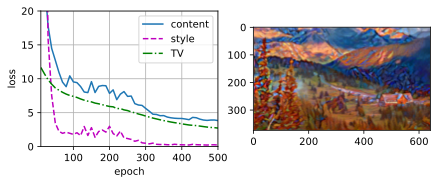

In [43]:
output = train(content_X, contents_Y, styles_Y, device, 0.9, 500, 50)

In [44]:
result_img = postprocess(output)

im = Image.fromarray((result_img.asnumpy()*255).astype(np.uint8))
im.save("./img/synthetized.jpg")